In [1]:
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
import astropy.constants as const 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 18

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

df = pd.read_csv("firas_monopole_spec_v1.txt", skiprows=18, delim_whitespace=True,
                 names=["freq", "intensity", "residual", "uncertainty", "poles_model"])

data = ascii.read("firas_monopole_spec_v1.txt")

From these data, estimate the maximum allowed value of the chemical po-
tential of photons (in units of
kT
CMB
) by allowing both the temperature
and chemical potential to vary, finding where the
χ
2
of your fit increases to
the point that the fit is poor (see Numerical Recipes, Chapter 15, esp. 15.6,
for advice on computing confidence intervals; available in course Dropbox).
Please state the confidence of your upper limit. Note: the variable definitions
and units can be tricky for this problem - please let me know if you need
help interpreting

In [2]:
#wanted to see the data 
print(df)

     freq  intensity  residual  uncertainty  poles_model
0    2.27    200.723         5           14            4
1    2.72    249.508         9           19            3
2    3.18    293.024        15           25           -1
3    3.63    327.770         4           23           -1
4    4.08    354.081        19           22            3
5    4.54    372.079       -30           21            6
6    4.99    381.493       -30           18            8
7    5.45    383.478       -10           18            8
8    5.90    378.901        32           16           10
9    6.35    368.833         4           14           10
10   6.81    354.063        -2           13           12
11   7.26    336.278        13           12           20
12   7.71    316.076       -22           11           25
13   8.17    293.924         8           10           30
14   8.62    271.432         8           11           36
15   9.08    248.239       -21           12           41
16   9.53    225.940         9 

In [3]:
firas_freq = (df["freq"].values * u.cm**(-1) * const.c).to(u.GHz)
firas_int = df["intensity"].values * u.MJy / u.sr

print(firas_freq.shape)

(43,)


In [4]:
print(firas_int.shape)

(43,)


In [5]:
firas_unc = df["uncertainty"].values * u.kJy / u.sr
print(firas_unc)

[ 14.  19.  25.  23.  22.  21.  18.  18.  16.  14.  13.  12.  11.  10.
  11.  12.  14.  16.  18.  22.  22.  23.  23.  23.  22.  21.  20.  19.
  19.  19.  21.  23.  26.  28.  30.  32.  33.  35.  41.  55.  88. 155.
 282.] kJy / sr


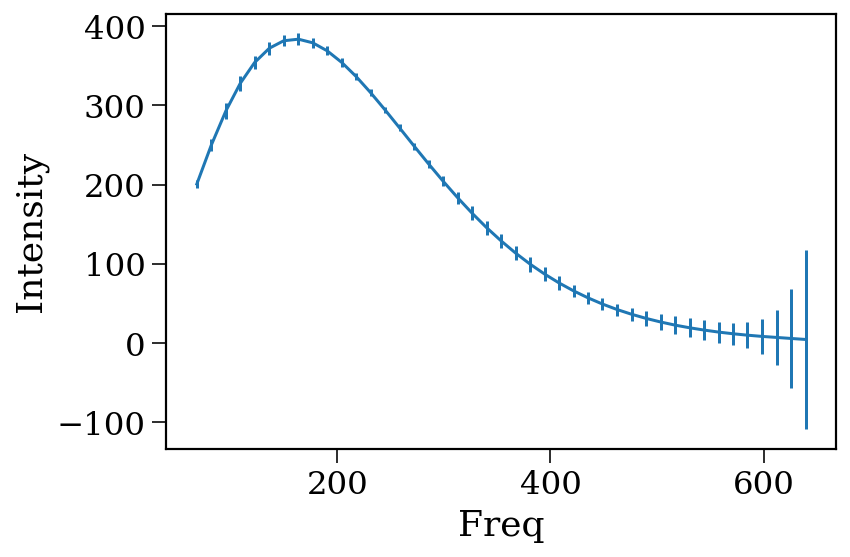

In [6]:
plt.errorbar(firas_freq, firas_int,yerr=firas_unc*400)
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [7]:
#need to create a definition for the planck function to vary temp and chemical potenital for later

import numpy as np

h = const.h #should be plancks constant in J s 
c = const.c #speed of light cm/s ?? 
kB = const.k_B #boltzmann constant in J/K
def bb_func(freq, mu, temp): #blackbody function
    a = 2*const.h*freq**3 
    #print((const.h * freq).unit)
    b = (const.h*freq - mu)/(const.k_B*temp)
    
    blackbody = a/const.c**2 * 1/(np.exp(b)-1)
    return blackbody.to(u.MJy)/u.sr

In [8]:
np.max(const.h*firas_freq)

<Quantity 4.23708894e-31 GHz J s>

In [9]:
work = 5e-31

In [10]:
bb = bb_func(firas_freq,0*u.erg,2.75*u.K)
bb.shape

(43,)

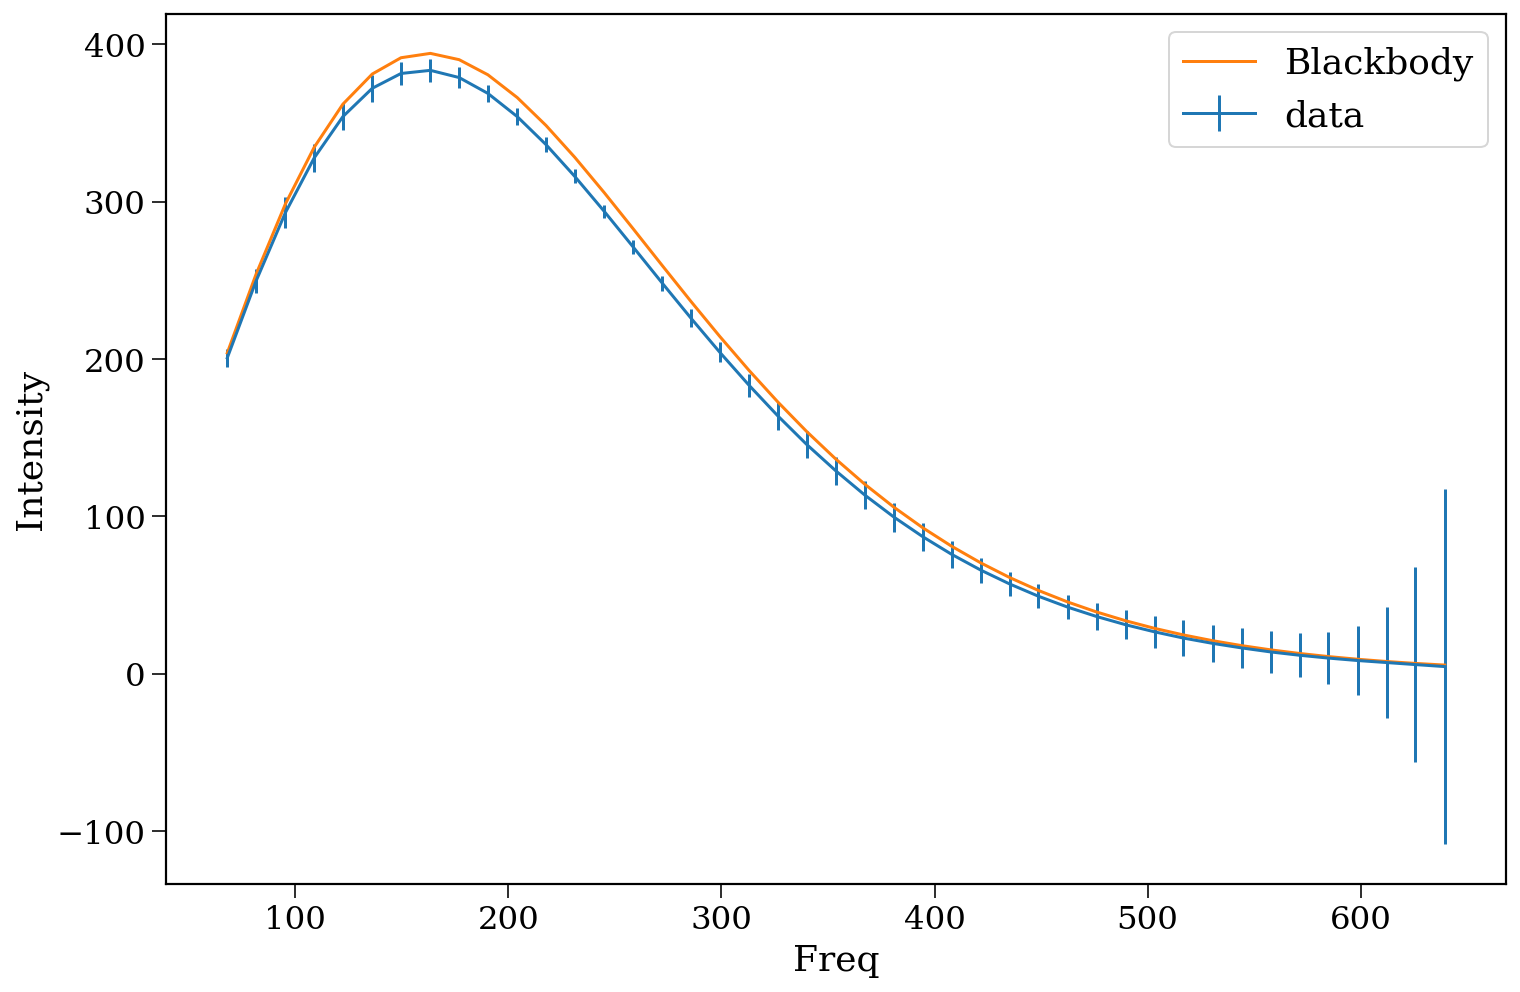

In [178]:
#wanting to see the data and see what values I Should be shooting for 
plt.errorbar(firas_freq, firas_int,yerr=firas_unc*400, label = 'data')
plt.plot(firas_freq, bb, label ='Blackbody')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [12]:
#making a chi squared model 

def chi_sq(data, model, uncert): 
    chi_squared = np.sum((data - model)**2 / uncert**2)
    return chi_squared

In [168]:
#need to make my arrays of chempot and temp again since I accidentally deleted them 

chempot = np.linspace(0, 5e-20,200)*u.erg #chemical potential 
T = np.linspace(2.7249, 2.7251,199)*u.K #REMEMBER THAT THE TEMP IS 99 AND IS THE FIRST ONE IN THE CHECK_cHISQ, temperature 
check_chisq = np.zeros((len(T), len(chempot)))
print(check_chisq.shape)

(199, 200)


In [169]:
#Running a grid so that I can make the contour plots for laterb 
for i in range(len(T)):
    for j in range(len(chempot)):
        check_bb = bb_func(firas_freq,chempot[j],T[i]) 
        check_chisq[i][j] = chi_sq(firas_int, check_bb, firas_unc).decompose().value

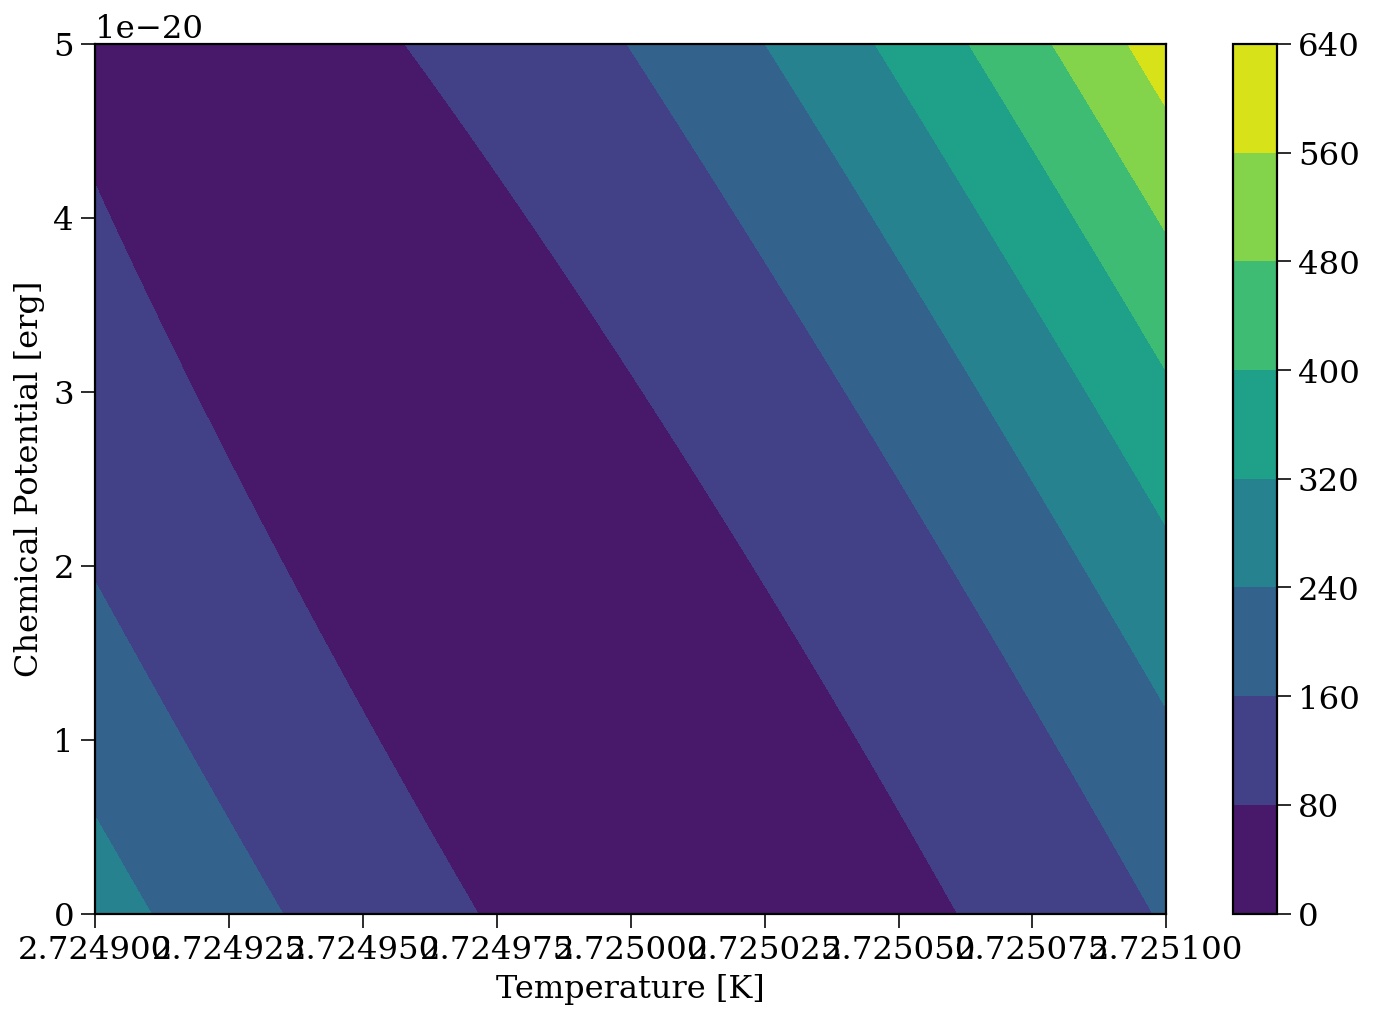

In [160]:
#need to make a contour plot so that we can start getting the confidence intervals and such 

contour = plt.contourf(T, chempot,np.transpose(check_chisq))
plt.colorbar(contour)
plt.xlabel('Temperature [K]', size=16)
plt.ylabel('Chemical Potential [erg]', size=16)
plt.show()

In [161]:
minchi = np.min(check_chisq)
minchi

44.98588143908379

In [171]:
#Cheching the confidence intervals over the grid that I made 
confidence = np.zeros([len(T), len(chempot)])
for i in range(len(check_chisq)):
    for j in range(len(check_chisq[i])):
        diff = check_chisq[i][j] - minchi
        if diff <= 1: #sigma 1 
            interval = 0
        elif diff > 1 and diff <=2.71: #sigma 2 
            interval = 1
        elif diff > 2.71 and diff <= 6.63: #sigma 3 
            interval = 2
        else:
            interval = 3
        confidence[i][j] = interval

In [172]:
confidence

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

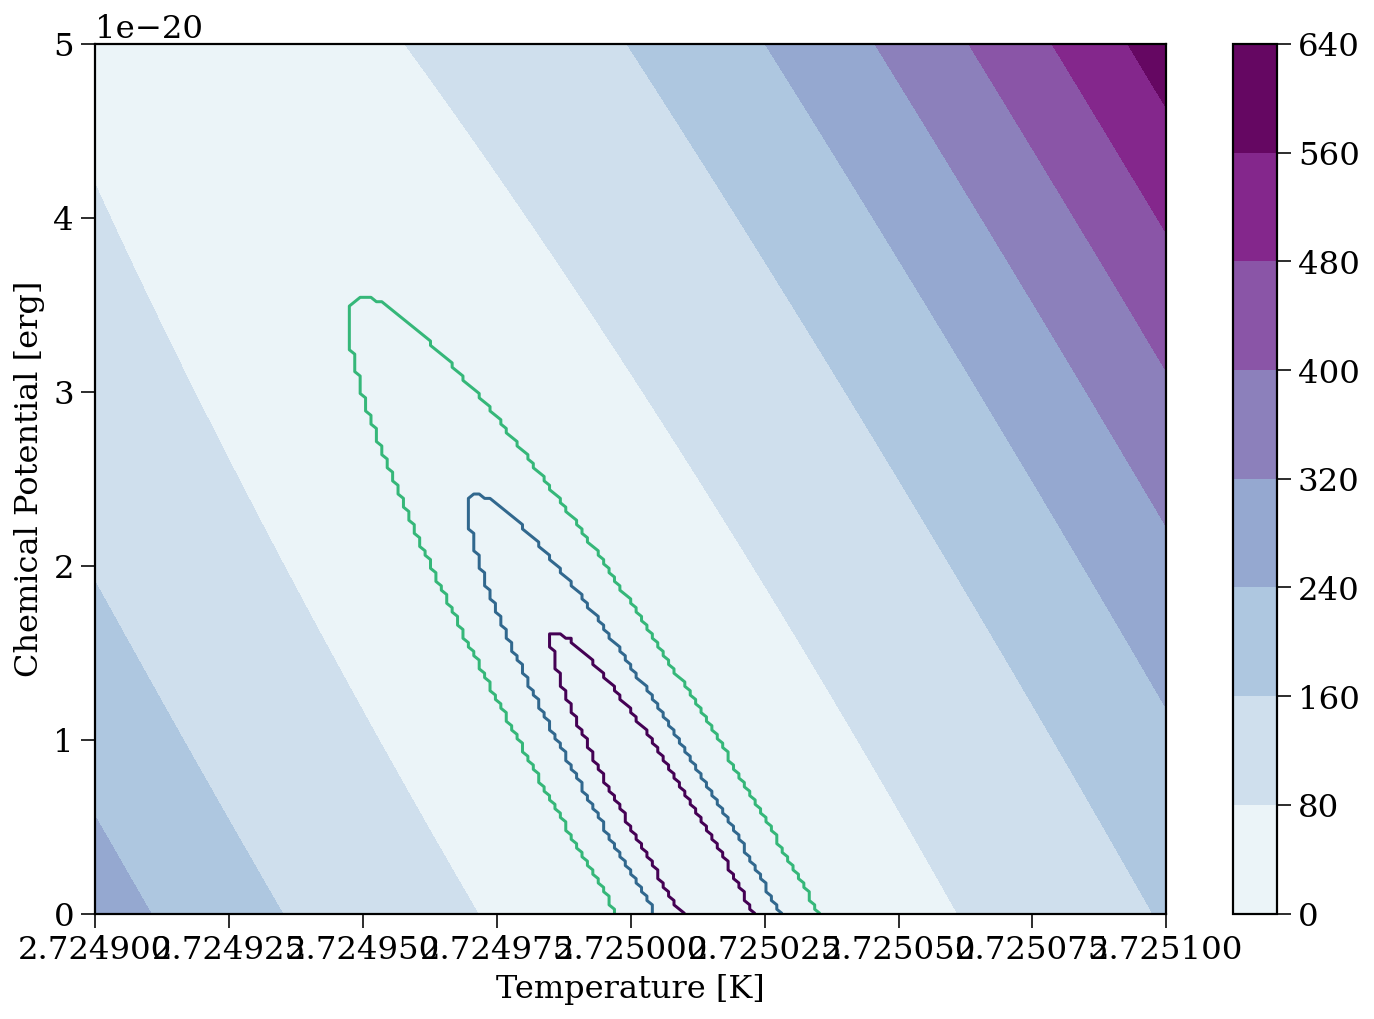

In [174]:
%config InlineBackend.figure_format = "retina"

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 18

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

#need to make a contour plot so that we can start getting the confidence intervals and such 
contour = plt.contourf(T, chempot,np.transpose(check_chisq), cmap = 'BuPu')
plt.contour(T, chempot,np.transpose(confidence), levels = [0,1,2,3])
plt.colorbar(contour)
plt.xlabel('Temperature [K]', size=16)
plt.ylabel('Chemical Potential [erg]', size=16)
plt.show()

In [177]:
#Okay now that I have the confidence interval contours set up I need to see what the upper limit of the interval is 

maxsigma1 = 0
maxsigma2 = 0
maxsigma3 = 0

for i in range(len(T)):
    for j in range(len(chempot)):
        if confidence[i][j] == 0:
            if chempot[j] > maxsigma1:
                maxsigma1 = chempot[j]
        elif confidence[i][j] == 1:
            if chempot[j] > maxsigma2:
                maxsigma2 = chempot[j]
        elif confidence[i][j] == 2:
            if chempot[j] > maxsigma3:
                maxsigma3 = chempot[j]
print('Chempot maximum of the 1 sigma confidence is: ',maxsigma1)
print('Chempot maximum of the 2 sigma confidence is: ',maxsigma2)
print('Chempot maximum of the 3 sigma confidence is: ',maxsigma3)

Chempot maximum of the 1 sigma confidence is:  1.608040201005025e-20 erg
Chempot maximum of the 2 sigma confidence is:  2.4120603015075375e-20 erg
Chempot maximum of the 3 sigma confidence is:  3.542713567839196e-20 erg
